In [1]:
import numpy as np 
import pandas as pd
import warnings
import eli5
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

sns.set_palette('dark')

warnings.filterwarnings('ignore')



# Getting the Data
The API tool used a recursive script to fetch 20+ different comma-separated files from Github. They were downloaded locally and will be read into Pandas in a loop.

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
dat_dir = "/Users/stephenhage/Github/National-File-B-Sample-File"
fileslist = list()
for file in os.listdir(dat_dir):
    if file.endswith(".zip"):
        if os.path.join(dat_dir, file) not in fileslist:
            fileslist.append(os.path.join(dat_dir, file))
        
dat_col_names = ["enterprise_flag", "record_num", "msa_code", "pct_minority", "income_ratio", "rent_affordability_cat", "mortgage_date", "loan_purpose", "fed_guarantee", "institution_type", "borrower_race", "coborrower_race", "borrower_gender", "coborrower_gender", "occupancy_code", "n_units", "unit_owner_occupied", "unit_affordability", "year"]
fileslist.sort()

The column `record_num` ought to be a unique identifier, but there are several repeated values. Just in case there are entire duplicated rows the `drop_duplicates()` function will be applied.

In [42]:
loans = pd.read_csv(fileslist[0], compression = 'zip', sep = ",", header = None, names = dat_col_names)
loans['datfile'] = fileslist[0]
for dat in fileslist[1:]:
    newdat = pd.read_csv(dat, compression = 'zip', sep = ",", header = None, names = dat_col_names)
    newdat['datfile'] = dat
    loans = loans.append(newdat, ignore_index = True)
    
loans = loans.drop_duplicates()


Many of the variables have a value of `9`, which represents either a missing value, an unknown value, or a not applicable value. It could be useful to count how many of these there are for each column.

In [4]:
## Missing values
for c in dat_col_names:
    print(c, ": ", len(loans[loans[c] == 9]))

enterprise_flag :  0
record_num :  20
msa_code :  0
pct_minority :  20819
income_ratio :  38979
rent_affordability_cat :  546563
mortgage_date :  118
loan_purpose :  192953
fed_guarantee :  0
institution_type :  0
borrower_race :  5743907
coborrower_race :  24994650
borrower_gender :  322530
coborrower_gender :  191676
occupancy_code :  0
n_units :  0
unit_owner_occupied :  0
unit_affordability :  3890622
year :  0


It may be worthwhile to plot the distributions as well, to see which variables have a particular skew.

[Text(0, 0.5, 'Occurrences'),
 Text(0.5, 0, 'Value'),
 Text(0.5, 1.0, 'Column unit_affordability')]

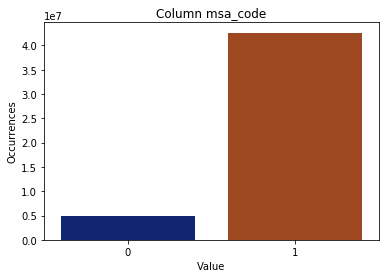

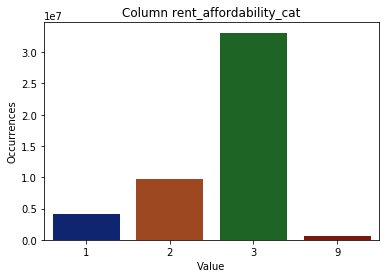

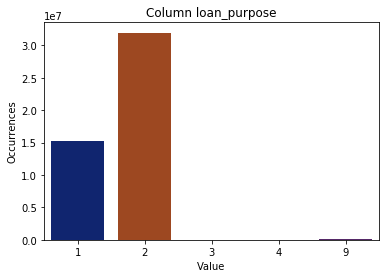

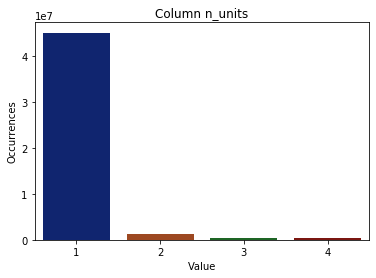

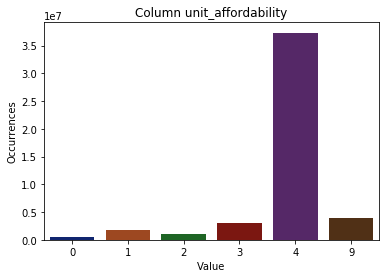

In [5]:
def plot_value_dist(col):
    plt_var = pd.DataFrame(loans[col].value_counts())
    plt.figure()
    outplt = sns.barplot(plt_var.index, plt_var[col]).set(title = f"Column {col}", xlabel = "Value", ylabel = "Occurrences")
    return outplt
    
# for c in loans.columns[2:-2]:
#     plot_value_dist(c)

plot_value_dist("msa_code")
plot_value_dist("rent_affordability_cat")
plot_value_dist("loan_purpose")
plot_value_dist("n_units")
plot_value_dist("unit_affordability")

There are a few variables that are exponentially distributed, namely `msa_code`, `rent_affordability_cat`, `loan_purpose`, `n_units` and `unit_affordability`. The bulk of loans are: 
* in urban areas
* lent to people making at least 80% of the median income in their area 
* for a home purchase or refinance
* single-unit
* not low-income or in a low-income area

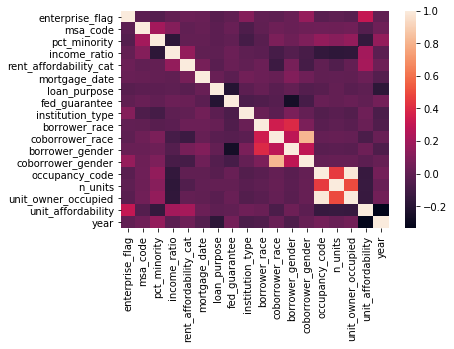

In [6]:
test_corr = loans[[c for c in loans.columns if c not in ['record_num']]].corr()
sns.heatmap(test_corr, annot = False)

Understanding that the values in this dataset are not ordinal, the actual correlation values can be taken with a grain of salt. This heat map, though, can be helpful in seeing which variables have relationships with which. For example, the number of units is strongly weakly related to the rent affordability category. Similarly, it appears that most coborrowers are the opposite sex of the borrower. This plot may help give guidance for model tweaking.

# Loan Data Exploratory Data Analysis

## Proportion of Fannie Mae Loans

In [8]:
round(len(loans.loc[loans.enterprise_flag == 1, 'enterprise_flag'].index)/len(loans.index), 2)

0.61

About 61% of all the loans in this dataset are with Fannie Mae, so as a baseline, models ought to correctly classify loans more than 61% of the time. 

The numeric labels are potentially confusing since they are not ordered (e.g. 1, 2, 3, 9). At the least, that obfuscates their meaning and may cause issues with modeling. When it comes time to build models the numbers will have to be encoded, but at this stage it makes more sense to use each value's meaning to understand the data we're working with.

In [43]:
data_definitions = {
    "enterprise_flag": {1: "FannieMae",
                       2: "FreddieMac"},
    "msa_code": {0: "NonMetroArea",
                1: "MetroArea"},
    'pct_minority': {1: "<10%",
                    2: "<30%",
                    3: "<100%",
                    9: "Missing"},
     'income_ratio': {1: "<=80%",
                     2: "<=120%",
                     3: ">120%",
                     9: "Missing"},
     'rent_affordability_cat': {1: "<=50%",
                               2: "<=80%",
                               3: ">80%",
                               9: "Missing"},
     'mortgage_date': {1: "Originated in same calendar year as acquired",
                      2: "Originated prior to calendar year of acquisition",
                      9: "Missing"},
     'loan_purpose': {1: "Purchase",
                     2: "Refinancing",
                     3: "Second Mortgate",
                     4: "Home Improvement/Rehabilitation",
                      9: "N/A"},
     'fed_guarantee': {1: "FHA/VA",
                      2: "Rural Housing Service (RHS) - guaranteed rural housing loan",
                      3: "Home Equity Conversion Mortgage (HECM)",
                      4: "No Federal guarantee ",
                      5: "Title 1 – FHA"},
     'institution_type': {1: "Mortgage company",
                         2: "SAIF",
                         3: "BIF",
                         4: "NCUA",
                         5: "Other/Unknown"},
     'borrower_race': {1: "American Indian or Alaska Native",
                        2: "Asian",
                        3: "Black or African American",
                        4: "Native Hawaiian or Other Pacific Islander",
                        5: "White",
                        6: "Two or more races",
                        7: "Hispanic or Latino",
                        9: "N/A"},
     'coborrower_race': {1: "American Indian or Alaska Native",
                        2: "Asian",
                        3: "Black or African American",
                        4: "Native Hawaiian or Other Pacific Islander",
                        5: "White",
                        6: "Two or more races",
                        7: "Hispanic or Latino",
                        9: "N/A"},
     'borrower_gender': {1: "Male",
                         2: "Female",
                         3: "not provided",
                         4: "N/A",
                         9: "Missing"},
     'coborrower_gender': {1: "Male",
                             2: "Female",
                             3: "not provided",
                             4: "N/A Fannie Mae",
                             5: "N/A Freddie Mac",
                             9: "Missing"},
     'occupancy_code': {1: "Owner-occupied",
                        2: "Rental unit in an owner-occupied property",
                        3: "Investment property",
                        9: "N/A"},
     'n_units': {},
     'unit_owner_occupied': {1: "Yes",
                            2: "No"},
     'unit_affordability': {1: "Low-income family in a low- income area",
                            2: "Very low-income family in a low-income area",
                            3: "Very low-income family not in a low-income area",
                            4: "Other",
                            9: "N/A",
                            0: "Missing"},
}

for col in dat_col_names:
    if col not in ['year', 'record_num']:
        loans = loans.replace({col: data_definitions[col]})
        
loans.head()

,enterprise_flag,record_num,msa_code,pct_minority,income_ratio,rent_affordability_cat,mortgage_date,loan_purpose,fed_guarantee,institution_type,borrower_race,coborrower_race,borrower_gender,coborrower_gender,occupancy_code,n_units,unit_owner_occupied,unit_affordability,year,datfile
0,FreddieMac,1,MetroArea,<30%,>120%,<=80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,BIF,White,White,Male,Male,Investment property,1,No,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
1,FreddieMac,2,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Purchase,No Federal guarantee,Mortgage company,White,White,Female,Male,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
2,FreddieMac,3,MetroArea,<10%,<=120%,>80%,Originated in same calendar year as acquired,Refinancing,No Federal guarantee,Mortgage company,White,White,Male,Female,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
3,FreddieMac,4,MetroArea,<30%,>120%,>80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,SAIF,N/A,N/A,Male,N/A Freddie Mac,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
4,FreddieMac,5,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Refinancing,No Federal guarantee,BIF,N/A,N/A,Male,Female,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...


Having human-readable labels makes the meaning of each column much clearer, and potentially easier to use (or drop) in models.

## Proportions of Missing Values

In [12]:
n_rows = len(loans.index)
missing_vals = dict()
for col in loans.columns:
    missing_vals[col] = len(loans.loc[(loans[col] == "Missing") | (loans[col] == "N/A"), col].index)/n_rows
    
pd.DataFrame.from_dict(missing_vals, orient = "index", columns = ['pct_missing']).sort_values('pct_missing', ascending = False)

,pct_missing
coborrower_race,0.53
borrower_race,0.12
unit_affordability,0.09
rent_affordability_cat,0.01
borrower_gender,0.01
loan_purpose,0.00
coborrower_gender,0.00
income_ratio,0.00
pct_minority,0.00
mortgage_date,0.00


Missing values (or N/A's) could potentially be improved with imputation. In the original data, these were often (but not always) represented with the number `9`. Understanding where there may be data quality concerns will not only help our modeling now, but will make data collection and future accuracy all the better.

More than half of `coborrower_race` values are unknown, which makes sense given that it isn't mandatory to have a cosigner. We're also missing about 12% of values for `borrower_race`. This is a significant amount, and begs the question whether that is a field worth collecting. Our models may benefit from imputation on this variable. 

Beyond that, we are missing about 9% of values for `unit_affordability`, which would seem to be a highly-important predictor for loan risk; it may also be important for knowing which institution is the lender. We're also missing 1% of `borrower_gender` and `rend_affordability_cat`.

## Proportions of Fannie Mae Loans by Variable

In [15]:
coded_vars = ['msa_code', 'pct_minority','income_ratio', 'rent_affordability_cat', 'mortgage_date',
       'loan_purpose', 'fed_guarantee', 'institution_type', 'borrower_race',
       'coborrower_race', 'borrower_gender', 'coborrower_gender',
       'occupancy_code', 'n_units', 'unit_owner_occupied',
       'unit_affordability']
def var_rates(var):
    small_df = loans[["enterprise_flag", var, "record_num"]]
    varrate = small_df.groupby(["enterprise_flag", var]).count()
    varrate = varrate.groupby(level=0).apply(lambda x: x / float(x.sum()))
    return varrate.unstack()

for var in coded_vars:
    print(var_rates(var))


                record_num             
msa_code         MetroArea NonMetroArea
enterprise_flag                        
FannieMae             0.90         0.10
FreddieMac            0.89         0.11
                record_num                   
pct_minority          <10% <100% <30% Missing
enterprise_flag                              
FannieMae             0.29  0.33 0.39    0.00
FreddieMac            0.32  0.30 0.38    0.00
                record_num                    
income_ratio        <=120% <=80% >120% Missing
enterprise_flag                               
FannieMae             0.44  0.13  0.43    0.00
FreddieMac            0.45  0.12  0.43    0.00
                       record_num                   
rent_affordability_cat      <=50% <=80% >80% Missing
enterprise_flag                                     
FannieMae                    0.09  0.21 0.70    0.01
FreddieMac                   0.08  0.20 0.70    0.02
                record_num                                            

The variables that have the most proportional difference between Fannie Mae and Freddie Mac loans are `institution_type` (the Seller Institution) and `unit_affordability`. This ignores `coborrower_gender`, which has unique `N/A` values assigned to each lender. 

Most values are distributed about the same for each variable aside from these. The difference in `institution_type` is that Freddie Mac is almost 1.5 as likely to be a loan coming from a Bank Insured Fund (62% of the loans for Freddie Mac are BIF, vs. only 42% for Fannie Mae). Conversely, Fannie Mae is much more likely to buy loans from mortgage companies (45% to 32%), Savings Associated Insurance Fund institutions (7% to 4%), or Credit Unions (4% vs. 2%).

For `unit_affordability`, the major differences are that Freddie Mac has all the N/A (as opposed to Missing) values, whereas Fannie Mae has far more `Other` values. 

The variable `occupancy_code` is potentially interesting as well, though the differences are far more subtle than the previous examples. Fannie Mae has a higher rate of `Investment Property` mortgages (10% vs. 8%) where Freddie Mac has more `Owner-occupied` loans.

In [ ]:
both_inst = loans.loc[loans.enterprise_flag == "FannieMae", ["enterprise_flag", "record_num", "datfile"]].merge(loans.loc[loans.enterprise_flag != "FannieMae", ["enterprise_flag", "record_num", "datfile"]], 
                                                                               how = "inner", on = "record_num").groupby("record_num").count()

# len(both_inst.index)/
both_inst

It is also noteworthy that 2461210 records are listed under both Fannie Mae and Freddie Mac. This is either very poor record-keeping, or `record_num` is not a unique identifier. Either way, it is a candidate to be removed from the analysis. 

# Data Cleaning

It's tempting to use all the data available and jam it through some machine learning algorithm to make predictions. But we've seen that some fields are not consistent, namely race fields for the borrower and coborrower. There are also enough missing values to cast doubt on the usefulness of `unit_affordability`. This section will evalute each variable to see which may be used, which may be transformed, and which should be ignored. 

With tens of millions of observations, we only lose a sliver by ignoring missing values for most variables (outside of `coborrower_race`). Even `coborrower_race` has a description:

> "Category 9 includes mortgages for which no co-borrower race or ethnicity is identified, originally coded as information not provided by the co- borrower in a mail or telephone application, no co-borrower, not applicable, or not available."

Since there is uncertainty whether it is missing *or* not applicable, caution would dictate ignoring those observations.

We also created a column called `datfile` to denote which file was used to read the data. This was potentially useful for analyzing duplicate values or other oddities, but can safely be dropped.

In [44]:
loans = loans.drop("datfile", axis = 1)
loans = loans[loans["pct_minority"] != "Missing"] 
loans = loans[loans["income_ratio"] != "Missing"] 
loans = loans[loans["rent_affordability_cat"] != "Missing"]
loans = loans[loans["mortgage_date"] != "Missing"]
loans = loans[loans["unit_affordability"] != "Missing"] 
loans = loans[loans["institution_type"] != "Other/Unknown"] 
loans = loans[loans["coborrower_gender"] != "Missing"] 
loans.loc[(loans.coborrower_gender == "N/A Fannie Mae") | (loans.coborrower_gender == "N/A Freddie Mac"), "coborrower_gender"] = "N/A" # combine NA types as coborrower gender

loans.shape

(45888667, 19)

In [ ]:
both_inst = loans.loc[loans.enterprise_flag == "FannieMae", ["enterprise_flag", "record_num", "datfile"]].merge(loans.loc[loans.enterprise_flag != "FannieMae", ["enterprise_flag", "record_num", "datfile"]], 
                                                                               how = "inner", on = "record_num").groupby("record_num").count()

both_inst

After removing the problematic values, we are left with 45888667 records, 2453842 `record_num`s of which are listed under **both** Fannie Mae and Freddie Mac. This analysis will not use `record_num` for models nor as an identifier, based on the assumption that a given unit can have been purchased or refinanced with mortgages from multiple lenders.

## Unusable Variables

We've discussed the field `record_num` is simply a reference number and can likely be ignored safely. The prevalance of missing values for `coborrower_race` shows that it may actually be more useful to know whether there is a cosigner, rather than the different categories of race. That could be added as a flag, and tested to see whether `coborrower_race` could be safely removed.

This analysis will keep all values for these fields with the understanding that they may be useful for an internal audit. That way we can be sure there aren't biases in our lending process.

## Building Attributes
Since we have the same `record_num` multiple times, and `year` is a field, it may be useful to see when the last loan on the unit happened. It could also be useful to see what the most recent loan type was. For the analysis we will create attributes for 
* last year the unit had a loan
* the reason for the most recent previous loan
* the affordability category for the previous loan
* the last lending institution

In [45]:
loans['last_record_num'] = loans.record_num.shift(1)
loans['last_loan_yr'] = loans.year.shift(1)
loans['last_loan_reason'] = loans.loan_purpose.shift(1)
loans['change_in_unit_affordability'] = loans.unit_affordability.shift(1)
loans['last_lender'] = loans.enterprise_flag.shift(1)
loans.loc[loans.record_num != loans.last_record_num, ['last_record_num', 'last_loan_reason', 'change_in_unit_affordability', 'last_lender']] = "N/A"

loans.loc[loans.record_num != loans.last_record_num, "last_loan_yr"] = 0

loans = loans.drop(['record_num', 'last_record_num'], axis = 1)
loans.head()

,enterprise_flag,msa_code,pct_minority,income_ratio,rent_affordability_cat,mortgage_date,loan_purpose,fed_guarantee,institution_type,borrower_race,...,coborrower_gender,occupancy_code,n_units,unit_owner_occupied,unit_affordability,year,last_loan_yr,last_loan_reason,change_in_unit_affordability,last_lender
0,FreddieMac,MetroArea,<30%,>120%,<=80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,BIF,White,...,Male,Investment property,1,No,N/A,2008,0.00,N/A,N/A,N/A
1,FreddieMac,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Purchase,No Federal guarantee,Mortgage company,White,...,Male,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
2,FreddieMac,MetroArea,<10%,<=120%,>80%,Originated in same calendar year as acquired,Refinancing,No Federal guarantee,Mortgage company,White,...,Female,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
3,FreddieMac,MetroArea,<30%,>120%,>80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,SAIF,N/A,...,N/A,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
4,FreddieMac,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Refinancing,No Federal guarantee,BIF,N/A,...,Female,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A


We want to preserve half the observations for out-of-sample testing, so we need to perform a random split the data now. That way we will have millions of unseen rows to test each model.

In [52]:
loan_train = loans.sample(frac = 0.5)
loan_train_y = loan_train.enterprise_flag
loan_test = loans.drop(loan_train.index)
loan_test_y = loan_test.pop("enterprise_flag")
loan_train.shape

(22944334, 22)

# Model Building

## Defining Success Metrics

Since Fannie Mae is the lending institution for about 61% of the records, there is a class imbalance to be considered. That imbalance is not enough to emphasize precision over accuracy, though it should be considered. Each model will be evaluated on test set accuracy and F1, which combines precision and recall measures.

This analysis also assumes that a false positive should be penalized more than a false negative, since it is likely more costly to try to do work with a loan that isn't owned by Fannie Mae than to miss an opportunity by wrongly believing a loan to originate with Freddie Mac.

Even "only" using half the data for training, we're still left with nearly 10mm rows, which is likely too much for a personal laptop to process. We will start with a small fraction of sampled observations and progressively sample more, until a representative set is obtained without taking inordinate time and memory.

## Starting Simple with Logistic Regression

### Code

In [131]:
X = loan_train.sample(frac = 0.5)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])
lm_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                             ('classifier', LogisticRegression(max_iter=10000, 
                                                        tol = 0.1,
                                                       class_weight = {"FannieMae": .45,
                                                                       "FreddieMac": .55}))])
lm_pipe.fit(X_train, y_train)
lm_pred = lm_pipe.predict(X_test)

In [54]:
lm_acc = round(lm_pipe.score(X_test, y_test), 3)
lm_f1 = round(f1_score(y_test, lm_pred, average = 'weighted'), 3)

print(f"Logistic Regression had an accuracy of {lm_acc} and an F1 score of {lm_f1}")

Logistic Regression had an accuracy of 0.687 and an F1 score of 0.68


In [55]:
def get_pred_rates(preds): 
    X_test['preds'] = preds
    X_test['enterprise_flag'] = y_test
    fannie_pred_rt = round(float(len(X_test.loc[X_test.preds == "FannieMae", "preds"].index)/len(X_test.index)), 4)
    actual_rt = round(float(len(X_test.loc[X_test.enterprise_flag == "FannieMae", "enterprise_flag"].index)/len(X_test.index)), 4)
    return [fannie_pred_rt, actual_rt]
    
lm_rt, actl_rt = get_pred_rates(lm_pred)
f"Logistic Regression is predicting Fannie Mae {100*lm_rt}% of the time, vs an actual rate of {100*actl_rt}%"

'Logistic Regression is predicting Fannie Mae 68.38% of the time, vs an actual rate of 61.150000000000006%'

The output of a basic logistic regression is only slightly better than if we had guessed "Fannie Mae" for every row. It is, in fact, predicting "Fannie Mae" the majority of the time. A heat map help see the distribution of predictions vs. actual loan originators.

### Plots

#### Heat Map

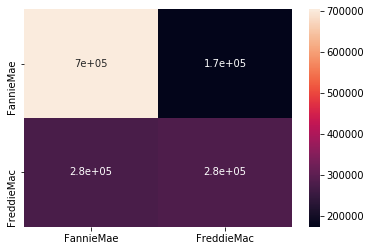

In [56]:
def make_heatmap(preds):
    labels = ["FannieMae", "FreddieMac"]
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot = True).set(yticklabels = labels, xticklabels = labels)

make_heatmap(lm_pred)

Logistic Regression does an admirable job of predicting Fannie Mae loans correctly, and has a relatively low False Positive rate. 

#### AUC

AUC: 0.6539035300655687


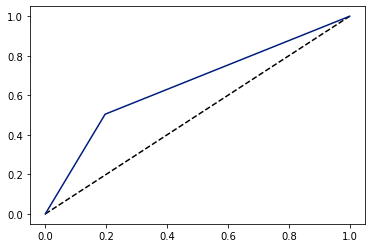

In [57]:

def auc_plot(preds):
    fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(preds == "FannieMae", 0, 1))
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc}")
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    
auc_plot(lm_pred)

The area under the curve is only 0.65, so there is a lot of room for improvement. This model, though, was built primarily to serve as a low-cost baseline rather than a productionized model.

### Misclassification by Category
There is always risk when including variables (such as race and gender) which are also covered by legal protections. They shouldn't be automatically ignored, but their bias ought to be evaluated before any model is deployed. 

#### Bias Evaluation

In [58]:
def test_preds(var, preds):
    df = X_test
    df['preds'] = preds
    df['enterprise_flag'] = y_test
    df["correct_preds"] = np.where(df['preds'] == df['enterprise_flag'], 1, 0)
    df["incorrect_preds"] = np.where(df['preds'] != df['enterprise_flag'], 1, 0)
    summed_by_var = df[[var, 'preds','correct_preds', 'incorrect_preds']].groupby([var, 'preds']).sum()
    summed_by_var['correct_pred_rt'] = summed_by_var.correct_preds/(summed_by_var.correct_preds + summed_by_var.incorrect_preds)
    return summed_by_var
test_preds('borrower_race', lm_pred)


correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae            2104   
                                          FreddieMac            266   
Asian                                     FannieMae           50330   
                                          FreddieMac          14374   
Black or African American                 FannieMae           24421   
                                          FreddieMac           6098   
Hispanic or Latino                        FannieMae           47073   
                                          FreddieMac          14867   
N/A                                       FannieMae           93487   
                                          FreddieMac          26497   
Native Hawaiian or Other Pacific Islander FannieMae            2327   
                                          FreddieMac            384   
Two or more races                         FannieMae            1281   
                                          FreddieMac           8565   
White                                     FannieMae          483475   
                                          FreddieMac         209967   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae               695   
                                          FreddieMac              207   
Asian                                     FannieMae             20573   
                                          FreddieMac            10317   
Black or African American                 FannieMae              8810   
                                          FreddieMac             4514   
Hispanic or Latino                        FannieMae             18356   
                                          FreddieMac            10292   
N/A                                       FannieMae             32236   
                                          FreddieMac            13997   
Native Hawaiian or Other Pacific Islander FannieMae               757   
                                          FreddieMac              232   
Two or more races                         FannieMae               286   
                                          FreddieMac             1413   
White                                     FannieMae            194384   
                                          FreddieMac           131436   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.75  
                                          FreddieMac             0.56  
Asian                                     FannieMae              0.71  
                                          FreddieMac             0.58  
Black or African American                 FannieMae              0.73  
                                          FreddieMac             0.57  
Hispanic or Latino                        FannieMae              0.72  
                                          FreddieMac             0.59  
N/A                                       FannieMae              0.74  
                                          FreddieMac             0.65  
Native Hawaiian or Other Pacific Islander FannieMae              0.75  
                                          FreddieMac             0.62  
Two or more races                         FannieMae              0.82  
                                          FreddieMac             0.86  
White                                     FannieMae              0.71  
                                          FreddieMac             0.62

Logistic regression has quite varied accuracy rates across the different races. While rates are high for American Indian and Two or more races, it had poor accuracy in classifying Freddie Mac loans across the board.

In [59]:
test_preds("borrower_gender", lm_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae          186184            75044             0.71
                FreddieMac          68307            47198             0.59
Male            FannieMae          461928           181422             0.72
                FreddieMac         196245           116506             0.63
Missing         FannieMae             309                0             1.00
                FreddieMac            905               91             0.91
N/A             FannieMae            1364               48             0.97
                FreddieMac              7                0             1.00
not provided    FannieMae           54713            19583             0.74
                FreddieMac          15554             8613             0.64

With regard to gender, the accuracy rate was best when the value was `Missing`, `N/A` or `not provided`. The model performed better with Fannie Mae predictions than Freddie Mac, with roughly equal success for male and female applicants.

In [60]:
test_preds("rent_affordability_cat", lm_pred)

correct_preds  incorrect_preds  \
rent_affordability_cat preds                                        
<=50%                  FannieMae           46027            21672   
                       FreddieMac          24999            30951   
<=80%                  FannieMae          154412            54540   
                       FreddieMac          57752            27039   
>80%                   FannieMae          504059           199885   
                       FreddieMac         198267           114418   

                                   correct_pred_rt  
rent_affordability_cat preds                        
<=50%                  FannieMae              0.68  
                       FreddieMac             0.45  
<=80%                  FannieMae              0.74  
                       FreddieMac             0.68  
>80%                   FannieMae              0.72  
                       FreddieMac             0.63

This model also had varied success with rent affordability. The model had better accuracy for predictions of "Fannie Mae" when the borrower's income was more than 50% of the local area's median. This model has some upward income bias that needs improvement, possibly by weighting predictions with other models.

In [61]:
test_preds("year", lm_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae           87301             8875             0.91
     FreddieMac          46754               90             1.00
2009 FannieMae          107936            10833             0.91
     FreddieMac          64680               70             1.00
2010 FannieMae           53142            25569             0.68
     FreddieMac          33330            37054             0.47
2011 FannieMae           72848            37389             0.66
     FreddieMac          12038            11802             0.50
2012 FannieMae          118083            58668             0.67
     FreddieMac           5870             5728             0.51
2013 FannieMae           93034            45550             0.67
     FreddieMac          19027            19263             0.50
2014 FannieMae           39450            17421             0.69
     FreddieMac          21055            20278             0.51
2015 FannieMae           41926            21424             0.66
     FreddieMac          27964            24176             0.54
2016 FannieMae           49823            26454             0.65
     FreddieMac          26306            27594             0.49
2017 FannieMae           40955            23914             0.63
     FreddieMac          23994            26353             0.48

Finally, logistic regression had success with in predicting Fannie Mae loans in earlier years, correctly classifying 91% or more loans for 2008-2009. There appear to be deteriorating results for predictions in more recent years.

In [134]:
def get_feature_importance(pipe):
    pipe_feature_names = pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
    return eli5.explain_weights(pipe.named_steps["classifier"], top = 50, feature_names = pipe_feature_names)
get_feature_importance(lm_pipe)

Weight?,Feature
+9.680,x15_N/A
+4.981,x5_N/A
+3.164,x6_Rural Housing Service (RHS) - guaranteed rural housing loan
+2.871,x10_Missing
+2.807,x6_FHA/VA
+2.353,x6_No Federal guarantee
+2.113,x5_Refinancing
+2.066,x5_Purchase
+1.904,x9_Two or more races
+1.124,x3_>80%


#### Notes for Model Improvement

The purpose of starting with logistic regression was not to accurately classify all loans, but rather to set a baseline for all other models. Accuracy could be improved with a grid search on a few paramaters, but it is doubtful we could squeeze more than 5% more predictive power out of it. Testing several other classifiers may help narrow down which to tune in order to improve.

## Stochastic Gradient Descent

One may ask, "why use another linear model?". Stochastic Gradient Descent has potential for more tuning than Logistic Regression at low computational cost. It is worth pursuing to see if perhaps it will represent either an improvement in predictive accuracy, or if it might be sensitive to variables to which our other model was not. If the latter case, we may be able to use each model's predictions to synthesize an improved model. 

In [94]:
X = loan_train.sample(frac = 0.8)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)


sgd_pipe = Pipeline(steps=[('preprocessor', preprocess_pipe),
                      ('classifier', SGDClassifier(n_jobs = -1, loss = "log", max_iter = 1000, early_stopping = True,
                                                  validation_fraction = .2))])


sgd_pipe.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=True, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001,

In [96]:
sgd_pred = sgd_pipe.predict(X_test)
sgd_acc = round(sgd_pipe.score(X_test, y_test), 3)
sgd_f1 = round(f1_score(y_test, sgd_pred, average = 'weighted'), 3)

print(f"Stochastic Gradient Descent had an accuracy of {sgd_acc} and an F1 score of {sgd_f1}")

Stochastic Gradient Descent had an accuracy of 0.693 and an F1 score of 0.668


### Plots

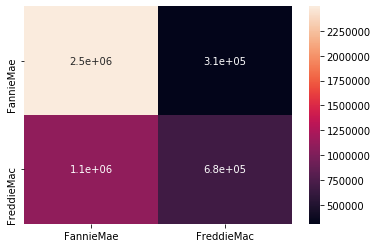

In [97]:
make_heatmap(sgd_pred)

SGD, oddly, had a higher rate of false negatives than did Logistic Regression. 

AUC: 0.6365881587925101


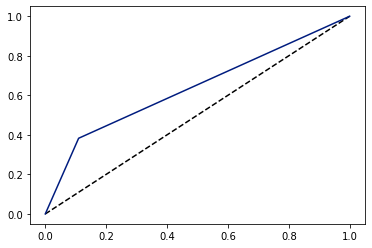

In [98]:
auc_plot(sgd_pred)

SGD did not represent an improvement over Logistic Regression on any of our metrics, though

In [129]:
get_feature_importance(sgd_pipe)

Weight?,Feature
+5.129,x15_N/A
+1.573,x9_Two or more races
+0.984,x10_Missing
+0.821,x7_BIF
+0.748,x5_Refinancing
+0.694,x5_Purchase
+0.619,x8_Two or more races
+0.614,x16_2015
+0.562,x16_2017
+0.530,x16_2016


SGD put the most weight on the housing `affordability_cat` variable, as the top predictor was having an `N/A` value. When the value was either `Other` or `Low-income family in a low-income area`, the weight is the lowest. 

We can interpret this as saying that our SGD model is most likely to classify a loan as "Fannie Mae" when there is an `N/A` value for `affordability_cat`, or when the `borrowers_race` was `Two or more races`. It is most likely to classify a loan as "Freddie Mac" when the loan originated between 2008-2009, or when the loan is for a low income family in a low-income area or `Other`.

### Misclassification by Category

In [66]:
test_preds('borrower_race', sgd_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae              79   
                                          FreddieMac              5   
Asian                                     FannieMae            2005   
                                          FreddieMac            529   
Black or African American                 FannieMae            1067   
                                          FreddieMac            204   
Hispanic or Latino                        FannieMae            1877   
                                          FreddieMac            522   
N/A                                       FannieMae            3863   
                                          FreddieMac            786   
Native Hawaiian or Other Pacific Islander FannieMae             130   
                                          FreddieMac              8   
Two or more races                         FannieMae              45   
                                          FreddieMac            378   
White                                     FannieMae           20231   
                                          FreddieMac           7677   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae                41   
                                          FreddieMac                5   
Asian                                     FannieMae               889   
                                          FreddieMac              404   
Black or African American                 FannieMae               400   
                                          FreddieMac              150   
Hispanic or Latino                        FannieMae               712   
                                          FreddieMac              348   
N/A                                       FannieMae              1531   
                                          FreddieMac              282   
Native Hawaiian or Other Pacific Islander FannieMae                27   
                                          FreddieMac                5   
Two or more races                         FannieMae                11   
                                          FreddieMac               54   
White                                     FannieMae              8538   
                                          FreddieMac             4558   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.66  
                                          FreddieMac             0.50  
Asian                                     FannieMae              0.69  
                                          FreddieMac             0.57  
Black or African American                 FannieMae              0.73  
                                          FreddieMac             0.58  
Hispanic or Latino                        FannieMae              0.72  
                                          FreddieMac             0.60  
N/A                                       FannieMae              0.72  
                                          FreddieMac             0.74  
Native Hawaiian or Other Pacific Islander FannieMae              0.83  
                                          FreddieMac             0.62  
Two or more races                         FannieMae              0.80  
                                          FreddieMac             0.88  
White                                     FannieMae              0.70  
                                          FreddieMac             0.63

In [ ]:
test_preds('borrower_gender', sgd_pred)

In [ ]:
test_preds('year', sgd_pred)

## K-Nearest Neighbors
In addition to using linear models to classify the loans, we could benefit by using a distance-based "voting" method like K-Nearest Neighbors. This model is much more computationally intense than its linear counterparts, so even with parallel processing we will need to use a much smaller sample to train the model. We will look for accuracy, yes, but also differences in bias. For example, if KNN performs with better accuracy on recent loans, it may supplement weaknesses in our previous models. 

In [67]:
X = loan_train.sample(frac = 0.001)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)


knn_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  KNeighborsClassifier(3, n_jobs = -1))])

knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)
knn_acc = round(knn_pipe.score(X_test, y_test), 3)
knn_f1 = round(f1_score(y_test, knn_pred, average = 'weighted'), 3)

print(f"KNN had an accuracy of {lm_acc} and an F1 score of {lm_f1}")

KNN had an accuracy of 0.687 and an F1 score of 0.68


In [68]:
knn_rt, actl_rt = get_pred_rates(knn_pred)
f"KNN Classifier is predicting Fannie Mae {knn_rt*100}% of the time, vs an actual rate of {actl_rt*100}%"

'KNN Classifieris predicting Fannie Mae 62.8% of the time, vs an actual rate of 62.06%'

### Plots

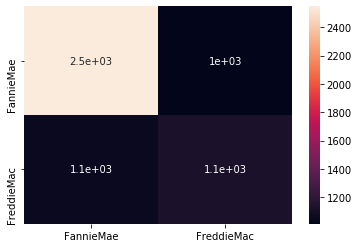

In [69]:
make_heatmap(knn_pred)

The F1 score improvement is telling; even on a very small sample we still have far fewer proportional false positive and false negative classifications. 

AUC: 0.6153074396893589


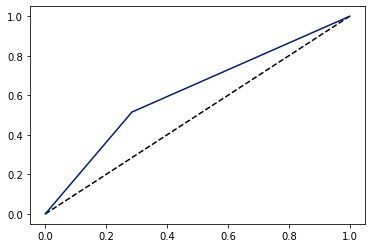

In [70]:
auc_plot(knn_pred)

The KNN model was a minor improvement on Logistic Regression despite being trained on a sample a fraction of the size. This was done because of intense compute time for the model, which could be improved with time to configure parallelization or distributed computing.

With a 69% accuracy rate it represents gains over previous models, though our secondary measures (F1 and AUC) suffer a bit. 

### Misclassification by Category

In [71]:
test_preds('borrower_race', knn_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae               9   
Asian                                     FannieMae             159   
                                          FreddieMac             63   
Black or African American                 FannieMae              88   
                                          FreddieMac             30   
Hispanic or Latino                        FannieMae             172   
                                          FreddieMac             58   
N/A                                       FannieMae             325   
                                          FreddieMac            103   
Native Hawaiian or Other Pacific Islander FannieMae               7   
                                          FreddieMac              2   
Two or more races                         FannieMae               7   
                                          FreddieMac             35   
White                                     FannieMae            1780   
                                          FreddieMac            830   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae                 1   
Asian                                     FannieMae                75   
                                          FreddieMac               62   
Black or African American                 FannieMae                30   
                                          FreddieMac               33   
Hispanic or Latino                        FannieMae                63   
                                          FreddieMac               69   
N/A                                       FannieMae               113   
                                          FreddieMac               93   
Native Hawaiian or Other Pacific Islander FannieMae                 2   
                                          FreddieMac                1   
Two or more races                         FannieMae                12   
                                          FreddieMac                2   
White                                     FannieMae               759   
                                          FreddieMac              753   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.90  
Asian                                     FannieMae              0.68  
                                          FreddieMac             0.50  
Black or African American                 FannieMae              0.75  
                                          FreddieMac             0.48  
Hispanic or Latino                        FannieMae              0.73  
                                          FreddieMac             0.46  
N/A                                       FannieMae              0.74  
                                          FreddieMac             0.53  
Native Hawaiian or Other Pacific Islander FannieMae              0.78  
                                          FreddieMac             0.67  
Two or more races                         FannieMae              0.37  
                                          FreddieMac             0.95  
White                                     FannieMae              0.70  
                                          FreddieMac             0.52

KNN produced much more variable accuracy by race, ranging from 37% to 95% by group. This is partially due to training on a small sample, but also reflects an insensitivity to `borrower_race`. This indicates that KNN, though it may not be the best model, may help the other models through weighting the predictions together.

## Random Forest

In [73]:
X = loan_train.sample(frac = 0.1)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)


rf_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  RandomForestClassifier(3, n_jobs = -1))])

rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, m

In [74]:
rf_pred = rf_pipe.predict(X_test)
rf_acc = round(rf_pipe.score(X_test, y_test), 3)
rf_f1 = round(f1_score(y_test, rf_pred, average = 'weighted'), 3)

print(f"Random Forest had an accuracy of {rf_acc} and an F1 score of {rf_f1}")

Random Forest had an accuracy of 0.693 and an F1 score of 0.679


### Plots

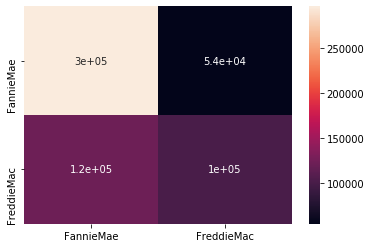

In [75]:
make_heatmap(rf_pred)


AUC: 0.6493591004066109


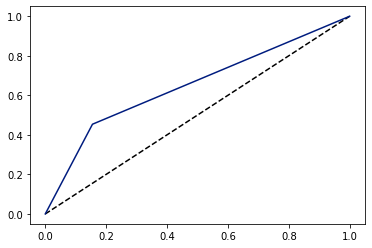

In [76]:
auc_plot(rf_pred)


Random Forest improves on all previous models on all three of our metrics (accuracy, F1, and AUC). This is true even though it was only trained on less than 10% of the training data. This is the most promising model thus far, and may be the best model to use given more computing resources in order to train and tune the model further.

In [150]:
rf_feature_names = rf_pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
eli5.explain_weights(rf_pipe.named_steps["classifier"], top = 25, feature_names = rf_feature_names[:79])


Weight,Feature
0.1678 ± 0.2186,x15_Low-income family in a low- income area
0.0961 ± 0.0848,x15_N/A
0.0870 ± 0.0248,x16_2008
0.0607 ± 0.0142,x6_Title 1 – FHA
0.0542 ± 0.0076,x15_Very low-income family not in a low-income area
0.0351 ± 0.0288,x3_<=50%
0.0288 ± 0.0325,x7_BIF
0.0282 ± 0.0497,x3_>80%
0.0205 ± 0.0274,x14_Yes
0.0179 ± 0.0239,x7_NCUA


Random Forest puts the most weight on `Low-income family in a low-income area` and `N/A` for `affordability_cat`, meaning it is most likely to classify a given loan as "Fannie Mae" when those are the values. A major difference from the previous models is that it is more likely than not to classify as "Fannie Mae" a loan from 2008.

### Misclassification by Category

In [77]:
test_preds('borrower_race', rf_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae             756   
                                          FreddieMac            164   
Asian                                     FannieMae           20754   
                                          FreddieMac           5581   
Black or African American                 FannieMae            9669   
                                          FreddieMac           2515   
Hispanic or Latino                        FannieMae           19472   
                                          FreddieMac           5240   
N/A                                       FannieMae           36901   
                                          FreddieMac          10690   
Native Hawaiian or Other Pacific Islander FannieMae             873   
                                          FreddieMac            225   
Two or more races                         FannieMae             844   
                                          FreddieMac           3369   
White                                     FannieMae          206819   
                                          FreddieMac          73491   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae               217   
                                          FreddieMac              138   
Asian                                     FannieMae              8707   
                                          FreddieMac             3554   
Black or African American                 FannieMae              3489   
                                          FreddieMac             1751   
Hispanic or Latino                        FannieMae              7938   
                                          FreddieMac             3382   
N/A                                       FannieMae             12702   
                                          FreddieMac             5878   
Native Hawaiian or Other Pacific Islander FannieMae               219   
                                          FreddieMac              211   
Two or more races                         FannieMae               235   
                                          FreddieMac              275   
White                                     FannieMae             88415   
                                          FreddieMac            39135   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.78  
                                          FreddieMac             0.54  
Asian                                     FannieMae              0.70  
                                          FreddieMac             0.61  
Black or African American                 FannieMae              0.73  
                                          FreddieMac             0.59  
Hispanic or Latino                        FannieMae              0.71  
                                          FreddieMac             0.61  
N/A                                       FannieMae              0.74  
                                          FreddieMac             0.65  
Native Hawaiian or Other Pacific Islander FannieMae              0.80  
                                          FreddieMac             0.52  
Two or more races                         FannieMae              0.78  
                                          FreddieMac             0.92  
White                                     FannieMae              0.70  
                                          FreddieMac             0.65

Random Forest has less racial variance than previous models, though it predicts "Freddie Mac" loans especially poorly for American Indian, Native Hawaiian, and African-American borrowers. Conversely, it predicts with very good accuracy "Freddie Mac" loans for `Two or more races` and "Fannie Mae" for `Native Hawaiian` borrowers.

In [78]:
test_preds('borrower_gender', rf_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae           79354            34038             0.70
                FreddieMac          23234            13759             0.63
Male            FannieMae          194500            80207             0.71
                FreddieMac          71225            37036             0.66
Missing         FannieMae             124                9             0.93
                FreddieMac            359                7             0.98
N/A             FannieMae             565               13             0.98
                FreddieMac             11                6             0.65
not provided    FannieMae           21545             7655             0.74
                FreddieMac           6446             3516             0.65

This model also shows little bias between male and female borrowers, with roughly equal accuracy in classifying both genders. 

In [79]:
test_preds('year', rf_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae           33356             2033             0.94
     FreddieMac          20181             1336             0.94
2009 FannieMae           41184             2274             0.95
     FreddieMac          27858             1766             0.94
2010 FannieMae           28701            15761             0.65
     FreddieMac           7924             7602             0.51
2011 FannieMae           27519            13068             0.68
     FreddieMac           6723             6781             0.50
2012 FannieMae           44009            20396             0.68
     FreddieMac           5379             5413             0.50
2013 FannieMae           38138            19675             0.66
     FreddieMac           6446             6526             0.50
2014 FannieMae           17728             8727             0.67
     FreddieMac           6498             6123             0.51
2015 FannieMae           18621            10769             0.63
     FreddieMac           9182             7655             0.55
2016 FannieMae           24842            14964             0.62
     FreddieMac           6361             6273             0.50
2017 FannieMae           21990            14255             0.61
     FreddieMac           4723             4849             0.49

Similar to previous models, RF had much higher accuracy on early records with deteriorating results on more recent loans. Interestingly, the dropoff in accuracy is far steeper than the others, moving from 90%+ accuracy in 2008-2009 to a 50% rate for "Freddie Mac" loans almost every year after.

### Gradient Boost

In [80]:
X = loan_train.sample(frac = 0.1)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)


xg_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  GradientBoostingClassifier())])

xg_pipe.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=No

In [81]:
xg_pred = xg_pipe.predict(X_test)
xg_acc = round(xg_pipe.score(X_test, y_test), 3)
xg_f1 = round(f1_score(y_test, xg_pred, average = 'weighted'), 3)

print(f"Gradient Boost had an accuracy of {xg_acc} and an F1 score of {xg_f1}")

Gradient Boost had an accuracy of 0.699 and an F1 score of 0.654


### Plots

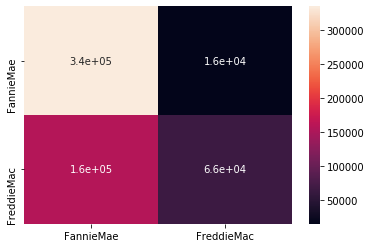

In [82]:
make_heatmap(xg_pred)


AUC: 0.6253169689239813


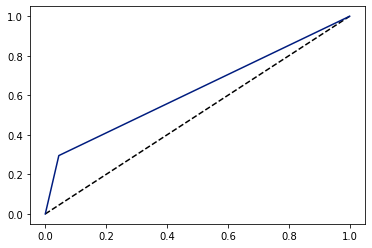

In [83]:
auc_plot(xg_pred)



Gradient Boost has the fastest initial climb on the AUROC plot, though the AUC is lower than for other models. We see that it has the highest accuracy, but also a relatively high rate of false negative predictions.

In [152]:
xg_feature_names = xg_pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
eli5.explain_weights(xg_pipe.named_steps["classifier"], top = 25, feature_names = xg_feature_names[:79])

Weight,Feature
0.5289 ± 0.4336,x15_Low-income family in a low- income area
0.1399 ± 0.3854,x16_2008
0.1201 ± 0.1835,x6_Title 1 – FHA
0.0739 ± 0.2111,x15_Very low-income family not in a low-income area
0.0360 ± 0.2382,x15_N/A
0.0202 ± 0.1785,x9_Native Hawaiian or Other Pacific Islander
0.0124 ± 0.2776,x7_NCUA
0.0089 ± 0.1507,x16_2011
0.0060 ± 0.1348,x16_2014
0.0053 ± 0.1056,x6_Home Equity Conversion Mortgage (HECM)


Similar to Random Forest, Gradient Boost picks up on the higher likelihood of a loan being with Fannie Mae when the `affordability_cat` is `Low-income family in a low-income area`. It also does so for a `Very low-income family not in a low-income area`, which is different from previous models. 

One other big difference is a high weighting of the variable `fed_guarantee`, where a value of `Title 1 - FHA` is more likely to be a Fannie Mae loan.

### Misclassification by Category

In [84]:
test_preds('borrower_race', xg_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae             867   
                                          FreddieMac             77   
Asian                                     FannieMae           23537   
                                          FreddieMac           3113   
Black or African American                 FannieMae           11079   
                                          FreddieMac           1435   
Hispanic or Latino                        FannieMae           22095   
                                          FreddieMac           3425   
N/A                                       FannieMae           41789   
                                          FreddieMac           6706   
Native Hawaiian or Other Pacific Islander FannieMae            1038   
                                          FreddieMac            118   
Two or more races                         FannieMae             988   
                                          FreddieMac           3216   
White                                     FannieMae          233780   
                                          FreddieMac          47668   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae               297   
                                          FreddieMac               26   
Asian                                     FannieMae             11092   
                                          FreddieMac              511   
Black or African American                 FannieMae              4506   
                                          FreddieMac              316   
Hispanic or Latino                        FannieMae              9725   
                                          FreddieMac              740   
N/A                                       FannieMae             16680   
                                          FreddieMac              948   
Native Hawaiian or Other Pacific Islander FannieMae               321   
                                          FreddieMac               23   
Two or more races                         FannieMae               336   
                                          FreddieMac              144   
White                                     FannieMae            114129   
                                          FreddieMac            12884   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.74  
                                          FreddieMac             0.75  
Asian                                     FannieMae              0.68  
                                          FreddieMac             0.86  
Black or African American                 FannieMae              0.71  
                                          FreddieMac             0.82  
Hispanic or Latino                        FannieMae              0.69  
                                          FreddieMac             0.82  
N/A                                       FannieMae              0.71  
                                          FreddieMac             0.88  
Native Hawaiian or Other Pacific Islander FannieMae              0.76  
                                          FreddieMac             0.84  
Two or more races                         FannieMae              0.75  
                                          FreddieMac             0.96  
White                                     FannieMae              0.67  
                                          FreddieMac             0.79

GB has the highest floor of predictions by group, with the lowest-accuracy group being "Fannie Mae" loans for White applicants (67%). That was an average rate for other models! GB proves to be a little more insensitive to `borrower_race`, which is a factor in favor of it being the model of choice.

In [85]:
test_preds('borrower_gender', xg_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae           88977            41362             0.68
                FreddieMac          15541             4619             0.77
Male            FannieMae          220968           105560             0.68
                FreddieMac          46029            10337             0.82
Missing         FannieMae             136               37             0.79
                FreddieMac            324                5             0.98
N/A             FannieMae             538                9             0.98
                FreddieMac              5                1             0.83
not provided    FannieMae           24554            10118             0.71
                FreddieMac           3859              630             0.86

GB, like other models, performs with almost equal accuracy on male and female borrowers. 

In [86]:
test_preds('year', xg_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae           34899             3530             0.91
     FreddieMac          18821               25             1.00
2009 FannieMae           43393             4232             0.91
     FreddieMac          25558                3             1.00
2010 FannieMae           35174            22609             0.61
     FreddieMac            985              511             0.66
2011 FannieMae           33684            18984             0.64
     FreddieMac            909              492             0.65
2012 FannieMae           49245            25014             0.66
     FreddieMac            853              422             0.67
2013 FannieMae           44684            24779             0.64
     FreddieMac           1035              379             0.73
2014 FannieMae           21704            12600             0.63
     FreddieMac           2917             2203             0.57
2015 FannieMae           17990             9436             0.66
     FreddieMac          10409             8230             0.56
2016 FannieMae           28336            17863             0.61
     FreddieMac           3353             2801             0.54
2017 FannieMae           26064            18039             0.59
     FreddieMac            918              526             0.64

Year continues to be a difficult variable to discern, since recent records perform much more poorly than early ones. The dropoff for GB is not as steep as for Random Forest, but after 2009 most years' accuracy is below 70%.

#### Notes for Model Improvement
GB is a candidate for big improvements with more computing resources, which would enable training on a much larger dataset than was possible on a local laptop.

# Model Selection

In [156]:
pd.DataFrame({"Logistic_Regression": {"Accuracy": lm_acc, "F1": lm_f1},
              "SGD": {"Accuracy": sgd_acc, "F1": sgd_f1},
               "KNN": {"Accuracy": knn_acc, "F1": knn_f1},
                "Random_Forest": {"Accuracy": rf_acc, "F1": rf_f1},
                 "Gradient_Descent": {"Accuracy": xg_acc, "F1": xg_f1}
                 })

,Logistic_Regression,SGD,KNN,Random_Forest,Gradient_Descent
Accuracy,0.69,0.69,0.64,0.69,0.70
F1,0.68,0.67,0.64,0.68,0.65


## Each Model's Blind Spots
None of the models vastly improved over our Logistic Regression benchmark. Gradient Boosting gained 1% in accuracy despite being trained on a sliver of the data of our linear models. This came at the cost of the F1 score.

All had worse results on loans after 2009 than before, which is of concern. While the linear models and KNN had varied results when broken down by race, the tree models (Random Forest and Gradient Boosting) were more robust to these differences.


## Further Considerations
This analysis was performed with about 45mm observations initially. Cleaning methods reduced that to about half. Some of that cleaning was necessary: 2mm records listed both lenders as the enterprise owning the loan. Other steps may have been extraneous, and given more time it may have been valuable to evaluate model performance including observation listed as `Missing` or `N/A`. That may hurt accuracy, but could allow processing of loan applications that contain missing values. A business decision would need to be made whether that tradeoff was worthwhile.

#### Further Feature Engineering
Though it wasn't mentioned in this write-up, models were initially tested on a fraction of the raw data. The best of these were barely more than 60% accurate. The `most-recent` features we created helped improve on that by as much as 10%. Creating more features, such as "number of previous loans" or "number of previous refinancing loans" may prove useful, as could a flag in the change in area poverty rates.

#### Dimensionality Reduction
Early tests with Principal Components Analysis did not yield substantive enough improvements over the base, cleaned data. In some datasets, pre-processing the data through orthoganal transforms can help make the decision to reduce dimensions, or at least to expedite model-building computations. This comes at the cost of obfuscating variables and their contribution to predictions. For this analysis, the tradeoffs were not acceptable and so PCA was not used.

#### More Compute Resources
This analysis was performed on a modern, powerful laptop (2018 MacBook Pro with 16GB of RAM). Yet, it took several minutes to train some models on small samples of the training set. This still represented hundreds of thousands of observations, but it was a huge limitation putting an upper bound on our accuracy. With additional time to configure GPU usage and optimization, or even training the models in the cloud, we could have used the full training set to improve our models.

#### Additional Data Sources
We achieved 70% accuracy with the models used, but that could undoubtedly be improved with access to more data sources. Having more observations may prove useful, but it could be invaluable to evaluate other metrics outside of this dataset. For example, there is undoubtedly a table with attributes of the borrower, of the unit's location, of rental occupancy rates, public transit, or other important factors. A much more robust approach to feature engineering using other facets of the lending relationship is likely the best source for improved model accuracy.

#### Ensembling the Models
Barring access to more data, each model run had strengths and weaknesses. Using a matrix optimization algorithm (such as Nelder-Mead) to weight predictions for each model on a validation data set could boost accuracy. For example, where Logistic Regression performed well on older records, Random Forest was adequate but had better accuracy recently. Furthermore, Logistic, KNN and Random Forest all are in different families of model, so blending their results through intelligent weighting may prove a 10% or more boon to our predictive power.

# Conclusion
No one model performed well on the train/test subset of the training data. Five models from three different "families" of modeling were developed. Each had different weights assigned to each variables, and each had their own biases. Some had different accuracy rates across genders and races. All struggled on records from recent loans. That is an indication that perhaps there were changes made in 2010 to laon policies, and additional data sources would help account for that. 

More compute resources and more business leader input would also help to further train the models. A 70% accuracy score is not ideal. Given these resources and time to tune the models would drastically improve accuracy scores.

These are the probabilities of each loan in the test data being a Fannie Mae loan:

In [ ]:
lm_test_pred = lm_pipe.predict_proba(loan_test)
sgd_test_pred = sgd_pipe.predict_proba(loan_test)
knn_test_pred = knn_pipe.predict_proba(loan_test)
rf_test_pred = rf_pipe.predict_proba(loan_test)
xg_test_pred = xg_pipe.predict_proba(loan_test)
pd.DataFrame({"log_pred": lm_test_pred,
             "sgd_pred": sgd_test_pred,
             "knn_pred": knn_test_pred,
             "rf_pred": rf_test_pred,
             "xg_pred": xg_test_pred,})


In [168]:
# X = loan_train.sample(frac = 0.01)
# y = X.enterprise_flag
# X = X.drop('enterprise_flag', axis = 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)


knn_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore")),
                             ("classifier", KNeighborsClassifier(3, n_jobs = -1))])
rf_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore")),
                             ("classifier", RandomForestClassifier(n_jobs = -1))])
xg_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore")),
                             ("classifier", GradientBoostingClassifier())])

knn_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
xg_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('enc',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', sparse=True)),
                ('classifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                         

**Data set:**
* The data to be used for this exercise is “Single-Family Public Use Database (PUDB) – National File B” API  data ( Refer to the API section “ Loan Data Tool Kit “) on The Exchange
* Note that in the ‘Co-borrower Gender’ field, the category 4 (not applicable) and category 5 (no co-borrower) should be treated as the same category and not used as distinct categories for modeling and projection as ‘4’ is the label reported by Fannie Mae and ‘5’ by Freddie Mac.

**Requirements:**
* Randomly select 50% of the data as a training set and the remaining 50% as a test set.
* Use the training set to estimate the probability that a loan is a Fannie Mae loan.
 
**Work to be delivered:**
* Python code (with clear notes) and results in a Jupyter notebook
* Explain the steps and methods you use in data processing, analyses, and modeling
* The outputs should include
** Probability that a loan will be a Fannie Mae loan
    - Metrics for evaluating model performance on the test set such as confusion matrix, AUROC or other accuracy measures
    - Charts and tables to illustrate your results if applicable
    - Explain your outcomes and insights obtained from the model. Show which features are most influential to your model prediction